# First notebook for the analysis of a basic compas run consisting of 20000 binaries. #

## General imports

In [41]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image

In [42]:
# set path to data file
path = '/home/louism/Thesis/data/COMPAS_Output_13/COMPAS_Output.h5'

# load the file
data = h5.File(path)

# inspect the data
list(data.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_Switch_Log',
 'BSE_System_Parameters',
 'Run_Details']

## Some additional functions

In [43]:
def printCompasDetails(data, *seeds, mask=()):
    """
    Function to print the full Compas output for given seeds, optionally with an additional mask
    """
    list_of_keys = list(data.keys())

    # Check if seed parameter exists - if not, just print without (e.g RunDetails)
    if ('SEED' in list_of_keys) | ('SEED>MT' in list_of_keys): # Most output files 
        #SEED>MT is a relic from older versions, but we leave this in for backwards compatibility

        # Set the seed name parameter, mask on seeds as needed, and set the index
        seedVariableName='SEED' if ('SEED' in list_of_keys) else 'SEED>MT'
        list_of_keys.remove(seedVariableName) # this is the index above, don't want to include it
    
        allSeeds = data[seedVariableName][()]
        seedsMask = np.in1d(allSeeds, seeds)
        if len(seeds) == 0: # if any seed is included, do not reset the mask
            seedsMask = np.ones_like(allSeeds).astype(bool)
        if mask == ():
            mask = np.ones_like(allSeeds).astype(bool)
        mask &= seedsMask

        df = pd.DataFrame.from_dict({param: data[param][()][mask] for param in list(data.keys())}).set_index(seedVariableName).T

    else: # No seed parameter, so do custom print for Run Details

        # Get just the keys without the -Derivation suffix - those will be a second column
        keys_not_derivations = []
        for key in list_of_keys:
            if '-Derivation' not in key:
                keys_not_derivations.append(key)
        
        # Some parameter values are string types, formatted as np.bytes_, need to convert back
        def convert_strings(param_array):
            if isinstance(param_array[0], np.bytes_):
                return param_array.astype(str)
            else:
                return param_array

        df_keys = pd.DataFrame.from_dict({param: convert_strings(data[param][()]) for param in keys_not_derivations }).T
        nCols = df_keys.shape[1] # Required only because if we combine RDs, we get many columns (should fix later)
        df_keys.columns = ['Parameter']*nCols
        df_drvs = pd.DataFrame.from_dict({param: convert_strings(data[param+'-Derivation'][()]) for param in keys_not_derivations }).T
        df_drvs.columns = ['Derivation']*nCols
        df = pd.concat([df_keys, df_drvs], axis=1)

    # Add units as first col
    units_dict = {key:data[key].attrs['units'].astype(str) for key in list_of_keys}
    df.insert(loc=0, column='(units)', value=pd.Series(units_dict))
    return df


In [44]:
def getMtEvents(MT):                                     
    """
    This function takes in the `BSE_RLOF` output category from COMPAS, and returns the information
    on the Mass Transfer (MT) events that happen for each seed. The events do not have to be in order, 
    either chronologically or by seed, this function will reorder them as required.
    
    OUT:
        tuple of (returnedSeeds, returnedEvents, returnedTimes)
        returnedSeeds (list): ordered list of the unique seeds in the MT file
        returnedEvents (list): list of sublists, where each sublist contains all the MT events for a given seed.
            MT event tuples take the form :
            (stellarTypePrimary, stellarTypeSecondary, isRlof1, isRlof2, isCEE)
        returnTimes (list): is a list of sublists of times of each of the MT events
    """

    mtSeeds = MT['SEED'][()]
    mtTimes = MT['Time<MT'][()]
    mtPrimaryStype = MT['Stellar_Type(1)<MT'][()]
    mtSecondaryStype = MT['Stellar_Type(2)<MT'][()]
    mtIsRlof1 = MT['RLOF(1)>MT'][()] == 1
    mtIsRlof2 = MT['RLOF(2)>MT'][()] == 1
    mtIsCEE = MT['CEE>MT'][()] == 1

    # We want the return arrays sorted by seed, so sort here.
    mtSeedsInds = np.lexsort((mtTimes, mtSeeds)) # sort by seeds then times - lexsort sorts by the last column first...
    mtSeeds = mtSeeds[mtSeedsInds]  
    mtTimes = mtTimes[mtSeedsInds]  
    mtPrimaryStype = mtPrimaryStype[mtSeedsInds]
    mtSecondaryStype = mtSecondaryStype[mtSeedsInds]
    mtIsRlof1 = mtIsRlof1[mtSeedsInds]
    mtIsRlof2 = mtIsRlof2[mtSeedsInds]
    mtIsCEE = mtIsCEE[mtSeedsInds]

    # Process the MT events

    returnedSeeds = []                                      # array of seeds - will only contain seeds that have MT events
    returnedEvents = []                                     # array of MT events for each seed in returnedSeeds
    returnedTimes = []                                      # array of times for each event in returnedEvents (for each seed in returnedSeeds)

    lastSeed = -1                                           # initialize most recently processed seed

    for seedIndex, thisSeed in enumerate(mtSeeds):          # iterate over all RLOF file entries
        thisTime = mtTimes[seedIndex]                       # time for this RLOF file entry
        thisEvent = (mtPrimaryStype[seedIndex], mtSecondaryStype[seedIndex], 
                     mtIsRlof1[seedIndex], mtIsRlof2[seedIndex], mtIsCEE[seedIndex])  # construct event tuple

        # If this is an entirely new seed:
        if thisSeed != lastSeed:                            # same seed as last seed processed?
            returnedSeeds.append(thisSeed)                  # no - new seed, record it
            returnedTimes.append([thisTime])                # initialize the list of event times for this seed
            returnedEvents.append([thisEvent])              # initialize the list of events for this seed
            lastSeed = thisSeed                             # update the latest seed

        # Add event, if it is not a duplicate
        try:
            eventIndex = returnedEvents[-1].index(thisEvent)  # find eventIndex of this particular event tuple in the array of events for this seed 
            if thisTime > returnedTimes[-1][eventIndex]:      # ^ if event is not a duplicate, this will throw a ValueError 
                returnedTimes[-1][eventIndex] = thisTime      # if event is duplicate, update time to the later of the duplicates
        except ValueError:                                    # event is not a duplicate:
            returnedEvents[-1].append(thisEvent)              # record new event tuple for this seed
            returnedTimes[-1].append(thisTime)                # record new event time for this seed

    return returnedSeeds, returnedEvents, returnedTimes       # see above for description

In [45]:
def getSnEvents(SN):                                     
    """
    This function takes in the `BSE_Supernovae` output category from COMPAS, and returns the information
    on the Supernova (SN) events that happen for each seed. The events do not have to be in order chronologically,
    this function will reorder them as required.
    
    OUT:
        tuple of (returnedSeeds, returnedEvents, returnedTimes)     
        returnedSeeds (list): ordered list of all the unique seeds in the SN file
        returnedEvents (list): list of sublists, where each sublist contains all the SN events for a given seed.
            SN event tuples take the form :
            (stellarTypeProgenitor, stellarTypeRemnant, whichStarIsProgenitor, isBinaryUnbound)
        returnedTimes (list): is a list of sublists of times of each of the SN events
    """
    
    snSeeds = SN['SEED'][()]
    snTimes = SN['Time'][()]
    snProgStype = SN['Stellar_Type_Prev(SN)'][()]
    snRemnStype = SN['Stellar_Type(SN)'][()]
    snWhichProg = SN['Supernova_State'][()]
    snIsUnbound = SN['Unbound'][()] == 1

    # We want the return arrays sorted by seed, so sort here.
    snSeedsInds = np.lexsort((snTimes, snSeeds)) # sort by seeds then times - lexsort sorts by the last column first...
    snSeeds = snSeeds[snSeedsInds]  
    snTimes = snTimes[snSeedsInds]  
    snProgStype = snProgStype[snSeedsInds]
    snRemnStype = snRemnStype[snSeedsInds]
    snWhichProg = snWhichProg[snSeedsInds]
    snIsUnbound = snIsUnbound[snSeedsInds]
    
    # Process the SN events

    returnedSeeds = []                                      # array of seeds - will only contain seeds that have SN events
    returnedEvents = []                                     # array of SN events for each seed in returnedSeeds
    returnedTimes = []                                      # array of times for each event in returnedEvents (for each seed in returnedSeeds)

    lastSeed = -1                                           # initialize most recently processed seed

    for seedIndex, thisSeed in enumerate(snSeeds):          # iterate over all SN file entries
        thisTime = snTimes[seedIndex]                       # time for this SN file entry
        thisEvent = (snProgStype[seedIndex], snRemnStype[seedIndex], 
                     snWhichProg[seedIndex], snIsUnbound[seedIndex]) # construct event tuple
               
        # If this is an entirely new seed:
        if thisSeed != lastSeed:                            # same seed as last seed processed?
            returnedSeeds.append(thisSeed)                  # no - new seed, record it
            returnedTimes.append([thisTime])                #   initialize the list of event times for this seed
            returnedEvents.append([thisEvent])              #   initialize the list of events for this seed
            lastSeed = thisSeed                             #   update the latest seed
        else:                                               # yes - second SN event for this seed
            returnedTimes[-1].append(thisTime)              #   append time at end of array
            returnedEvents[-1].append(thisEvent)            #   append event at end of array
                
    return returnedSeeds, returnedEvents, returnedTimes     # see above for description

In [46]:
def getEventHistory(h5file, exclude_null=False):
    """
    Get the event history for all seeds, including both RLOF and SN events, in chronological order.
    IN:
        h5file (h5.File() type): COMPAS HDF5 output file
        exclude_null (bool): whether or not to exclude seeds which undergo no RLOF or SN events
    OUT:
        tuple of (returnedSeeds, returnedEvents)
        returnedSeeds (list): ordered list of all seeds in the output
        returnedEvents (list): a list of the collected SN and MT events from the 
            getMtEvents and getSnEvents functions above
    """

    SP = h5file['BSE_System_Parameters']
    MT = h5file['BSE_RLOF']
    SN = h5file['BSE_Supernovae']
    allSeeds = SP['SEED'][()]                                              # get all seeds
    mtSeeds, mtEvents, mtTimes = getMtEvents(MT)                           # get MT events
    snSeeds, snEvents, snTimes = getSnEvents(SN)                           # get SN events

    numMtSeeds = len(mtSeeds)                                               # number of MT events
    numSnSeeds = len(snSeeds)                                               # number of SN events

    if numMtSeeds < 1 and numSnSeeds < 1: return []                         # no events - return empty history

    returnedSeeds = []                                                      # array of seeds - will only contain seeds that have events (of any type)
    returnedEvents = []                                                     # array of events - same size as returnedSeeds (includes event times)

    eventOrdering = ['MT', 'SN']                                            # order of preference for simultaneous events

    mtIndex = 0                                                             # index into MT events arrays
    snIndex = 0                                                             # index into SN events arrays

    if exclude_null:
        seedsToIterate = np.sort(np.unique(np.append(mtSeeds, snSeeds)))    # iterate over all the seeds that have either MT or SN events
    else:
        seedsToIterate = allSeeds
        
    idxOrdered = np.argsort(seedsToIterate)
    returnedSeeds = [None] * np.size(seedsToIterate)                        # array of seeds - will only contain seeds that have events (of any type)
    returnedEvents = [None] * np.size(seedsToIterate)                       # array of events - same size as returnedSeeds (includes event times)

    for idx in idxOrdered:
        seed = seedsToIterate[idx]
        seedEvents = []                                                     # initialise the events for the seed being processed

        # Collect any MT events for this seed, add the time of the event and the event type
        while mtIndex < numMtSeeds and mtSeeds[mtIndex] == seed:
            for eventIndex, event in enumerate(mtEvents[mtIndex]):
                seedEvents.append(('MT', mtTimes[mtIndex][eventIndex], *mtEvents[mtIndex][eventIndex]))
            mtIndex += 1

        # Collect any SN events for this seed, add the time of the event and the event type 
        while snIndex < numSnSeeds and snSeeds[snIndex] == seed:
            for eventIndex, event in enumerate(snEvents[snIndex]):
                seedEvents.append(('SN', snTimes[snIndex][eventIndex], *snEvents[snIndex][eventIndex]))
            snIndex += 1

        seedEvents.sort(key=lambda ev:(ev[1], eventOrdering.index(ev[0])))  # sort the events by time and event type (MT before SN if at the same time)

        returnedSeeds[idx] = seed                                           # record the seed in the seeds array being returned
        returnedEvents[idx] = seedEvents                                    # record the events for this seed in the events array being returned

    return returnedSeeds, returnedEvents                                    # see above for details

In [47]:
SLs = data['BSE_Switch_Log']

SPs = data['BSE_System_Parameters']
sps = printCompasDetails(SPs)
RLOF = data['BSE_RLOF']

CEs = data['BSE_Common_Envelopes']

In [48]:
SPs.keys()

<KeysViewHDF5 ['Experienced_SN_Type(1)', 'Experienced_SN_Type(2)', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)<CE', 'Mass(1)>CE', 'Mass(2)<CE', 'Mass(2)>CE', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Mass_Core(1)', 'Mass_Core(2)', 'Mass_Core@CE(1)', 'Mass_Core@CE(2)', 'Mass_Core@CO(1)', 'Mass_Core@CO(2)', 'Mass_He_Core(1)', 'Mass_He_Core(2)', 'Mass_He_Core@CE(1)', 'Mass_He_Core@CE(2)', 'Mass_He_Core@CO(1)', 'Mass_He_Core@CO(2)', 'Record_Type', 'SEED', 'SemiMajorAxis<CE', 'SemiMajorAxis>CE', 'SemiMajorAxis@ZAMS', 'Stellar_Type(1)', 'Stellar_Type(1)<CE', 'Stellar_Type(1)>CE', 'Stellar_Type(2)', 'Stellar_Type(2)<CE', 'Stellar_Type(2)>CE', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'Unbound']>

## Tasks:
- histogram showing amount of stripped stars
- time spent on each phase
- scatterplot of mass vs time spent as stripped star; differentiate between self-stripped and binary-stripped, differentiate betweens tars still in binary or disrupted binary

## Written functions

- code for plotting the histogram of all stellar types in the COMPAS run at ZAMS and at the end of the simulation

In [10]:
def stellar_types_histogram(data):

    bins = np.arange(0, 16 + 1.5) - 0.5
    xtix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    
    SPs = data["BSE_System_Parameters"]

    zams_type_primary = np.array(SPs['Stellar_Type@ZAMS(1)'][()])
    zams_type_secundary = np.array(SPs['Stellar_Type@ZAMS(2)'][()])

    term_type_primary = np.array(SPs['Stellar_Type(1)'][()])
    term_type_secundary = np.array(SPs['Stellar_Type(2)'][()])
    
    fig, ax = plt.subplots(2,2, figsize=(14,10))
    
    ax[0][0].set_title("Stellar Types at ZAMS")
    
    counts00, edges00, bars00 = ax[0][0].hist(zams_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[0][0].set_ylabel("Amount")
    ax[0][0].set_xticks(xtix)
    ax[0][0].legend()
    ax[0][0].set_xlabel("Stellar Types")
    ax[0][0].bar_label(bars00)
    
    counts01, edges01, bars01 = ax[0][1].hist(zams_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[0][1].set_ylabel("Amount")
    ax[0][1].set_xticks(xtix)
    ax[0][1].legend()
    ax[0][1].set_xlabel("Stellar Types")
    ax[0][1].bar_label(bars01)
    
    ax[1][0].set_title("Final Stellar Types")
    
    counts10, edges10, bars10 = ax[1][0].hist(term_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[1][0].set_ylabel("Amount")
    ax[1][0].set_xticks(xtix)
    ax[1][0].legend()
    ax[1][0].bar_label(bars10)
    
    counts11, edges11, bars11 = ax[1][1].hist(term_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[1][1].set_ylabel("Amount")
    ax[1][1].set_xticks(xtix)
    ax[1][1].legend()
    ax[1][1].bar_label(bars11)
    ax[1][1].set_xlabel("Stellar Types")
    
    plt.show()

# Analysis

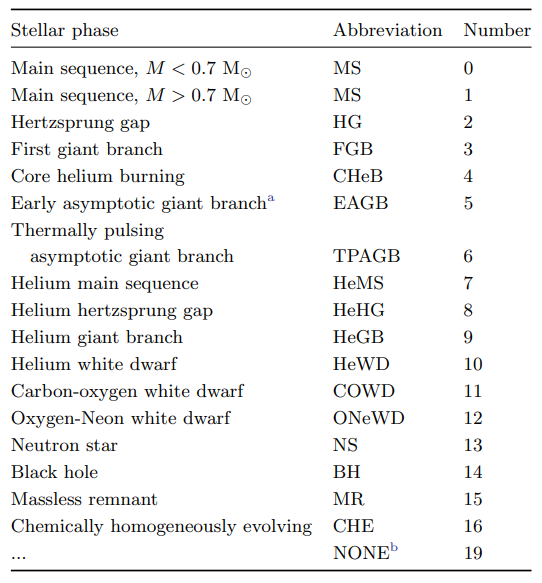

In [11]:
Image("/home/louism/Thesis/COMPAS_stellar_types.png")

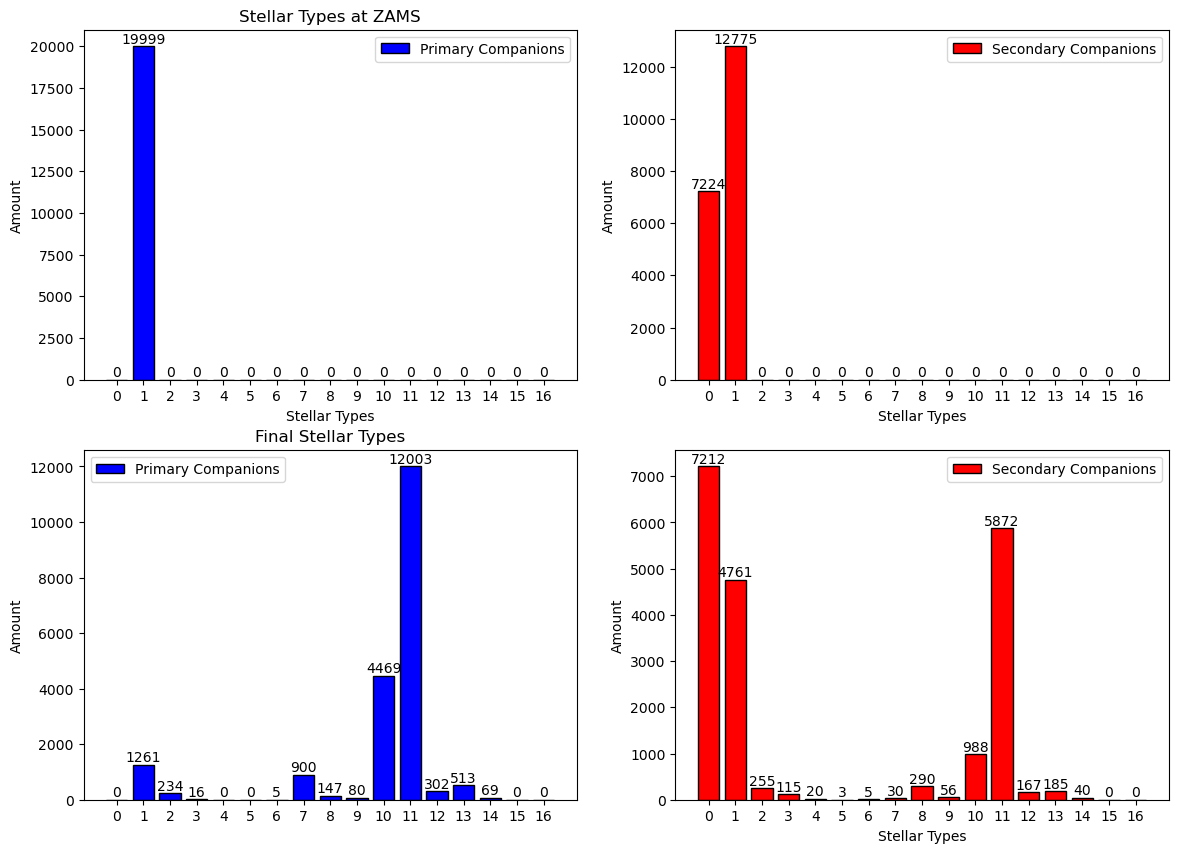

In [12]:
stellar_types_histogram(data)

# Study the time each star spent as a stripped star with respect to their initial masses

## Perform some masking to get datasets consisting of:
- Binary stripped stars (mass transfer) that remain in a binary - have undergone stable or unstable MT (common-envelope evolution)
- Binary stripped stars (mass transfer) that do not remain in a binary - have undergone stable or unstable MT (common-envelope evolution)
- Stars that stripped themselves and do or do not remain in a binary

### Masking for the bound seeds that have been stripped in a binary process

In [13]:
# 1) Bound seeds
Bound_mask = (SPs['Unbound'][()] == 0)
Bound_seeds = SPs['SEED'][Bound_mask]

# 2) Bound Common-Envelope systems and standard RLOF systems
BoundCE_seeds = np.intersect1d(CEs['SEED'][()], Bound_seeds)
RLOF_seeds = np.setdiff1d(RLOF['SEED'][()], CEs['SEED'][()])
BoundRLOF_seeds = np.intersect1d(RLOF_seeds, Bound_seeds)

# 3) systems for which the primary/secondary has been stripped
RLOFStripped_mask1 = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [7,8,9])
RLOFStripped_mask2 = np.in1d(RLOF['Stellar_Type(2)>MT'][()], [7,8,9])
BoundRLOFStripped_seeds1 = np.intersect1d(BoundRLOF_seeds, RLOF['SEED'][RLOFStripped_mask1])
BoundRLOFStripped_seeds2 = np.intersect1d(BoundRLOF_seeds, RLOF['SEED'][RLOFStripped_mask2])

CEStripped_mask1 = (SPs['Stellar_Type(1)<CE'][()] < 7) & np.in1d(SPs['Stellar_Type(1)>CE'][()], [7,8,9])
CEStripped_mask2 = (SPs['Stellar_Type(2)<CE'][()] < 7) & np.in1d(SPs['Stellar_Type(2)>CE'][()], [7,8,9])
BoundCEStripped_seeds1 = np.intersect1d(BoundCE_seeds, SPs['SEED'][CEStripped_mask1])
BoundCEStripped_seeds2 = np.intersect1d(BoundCE_seeds, SPs['SEED'][CEStripped_mask2])

### Masking for the bound seeds that have been stripped in a binary process

In [14]:
# 2) Unbound Common-Envelope systems and standard RLOF systems
UnboundCE_seeds = np.setdiff1d(CEs['SEED'][()], Bound_seeds)
UnboundRLOF_seeds = np.setdiff1d(RLOF_seeds, Bound_seeds)

# 3) systems for which the primary/secondary has been stripped
UnboundRLOFStripped_seeds1 = np.intersect1d(UnboundRLOF_seeds, RLOF['SEED'][RLOFStripped_mask1])
UnboundRLOFStripped_seeds2 = np.intersect1d(UnboundRLOF_seeds, RLOF['SEED'][RLOFStripped_mask2])

UnboundCEStripped_seeds1 = np.intersect1d(UnboundCE_seeds, SPs['SEED'][CEStripped_mask1])
UnboundCEStripped_seeds2 = np.intersect1d(UnboundCE_seeds, SPs['SEED'][CEStripped_mask2])

### Masking for stars that stripped themselves

In [15]:
# 1) systems without MT
MT_seeds = np.union1d(CEs['SEED'][()], RLOF['SEED'][()])
NoMT_seeds = np.setdiff1d(SPs['SEED'][()], MT_seeds)

# 2) have stripped
Stripped_mask1 = (SLs['Star_Switching'][()] == 1) & np.in1d(SLs['Switching_To'][()], [7,8,9])
Stripped_mask2 = (SLs['Star_Switching'][()] == 2) & np.in1d(SLs['Switching_To'][()], [7,8,9])

Stripped_seeds1 = np.intersect1d(NoMT_seeds, np.unique(SLs['SEED'][Stripped_mask1]))
Stripped_seeds2 = np.intersect1d(NoMT_seeds, np.unique(SLs['SEED'][Stripped_mask2]))

## Defining the functions to be used to extract the data

In [16]:
def getInitialMass(seed, PrimarySecondary):
    if PrimarySecondary == 1:
        mass = sps.loc[['Mass@ZAMS(1)'], seed].iloc[0]
    if PrimarySecondary == 2:
        mass = sps.loc[['Mass@ZAMS(2)'], seed].iloc[0]
    return mass

def getMassBeforeCE(seed, PrimarySecondary):
     if PrimarySecondary == 1:
        mass = sps.loc[['Mass(1)<CE'], seed].iloc[0]
     if PrimarySecondary == 2:
        mass = sps.loc[['Mass(2)<CE'], seed].iloc[0]
     return mass

def getMassAfterCE(seed, PrimarySecondary):
     if PrimarySecondary == 1:
        mass = sps.loc[['Mass(1)>CE'], seed].iloc[0]
     if PrimarySecondary == 2:
        mass = sps.loc[['Mass(2)>CE'], seed].iloc[0]
     return mass

def getTimeStripped(seed, PrimarySecondary):
    
    sls = printCompasDetails(SLs, seed)
    sls_data = np.array(sls.to_numpy())
    sls_data = sls_data[:, 1:].astype(float)
    primary_mask = sls_data[0][()] == 1
    secondary_mask = sls_data[0][()] == 2
    stripped_mask1 = sls_data[2][primary_mask] >= 7
    stripped_mask2 = sls_data[2][secondary_mask] >= 7
    if PrimarySecondary == 1:
        time = sls_data[3][primary_mask][stripped_mask1][-1]-sls_data[3][primary_mask][stripped_mask1][0]
    if PrimarySecondary == 2:
        time = sls_data[3][secondary_mask][stripped_mask2][-1]-sls_data[3][secondary_mask][stripped_mask2][0]
    return time

def getCompanion(seed, PrimarySecondary):
    if PrimarySecondary == 1:
        companion = sps.loc[['Stellar_Type(2)'], seed][0]
    if PrimarySecondary == 2:
        companion = sps.loc[['Stellar_Type(1)'], seed][0]
    return companion

def getType(seed, PrimarySecondary):
    if PrimarySecondary == 1:
        Type = sps.loc[['Stellar_Type(1)'], seed][0]
    if PrimarySecondary == 2:
        Type = sps.loc[['Stellar_Type(2)'], seed][0]
    return Type

def getInitialSemiMajorAxis(seed):
    semi = sps.loc[['SemiMajorAxis@ZAMS'], seed][0]
    return semi

def getSemiMajorAxisPostCe(seed):
    semi = sps.loc[['SemiMajorAxis>CE'], seed][0]
    return semi

def getSemiMajorAxisBeforeCe(seed):
    semi = sps.loc[['SemiMajorAxis<CE'], seed][0]
    return semi

def MassVsTimeSpentStripped(seeds, PrimarySecondary):
    init_mass = []
    time = []
    Type = []
    CompanionType = []
    SemiMajor = []

    massBeforeCe = []
    massAfterCe = []
    
    
    for seed in seeds:
        time.append(getTimeStripped(seed, PrimarySecondary))
        init_mass.append(getInitialMass(seed, PrimarySecondary))
        Type.append(getType(seed, PrimarySecondary))
        CompanionType.append(getCompanion(seed, PrimarySecondary))
        SemiMajor.append(getInitialSemiMajorAxis(seed))
        massBeforeCe.append(getMassBeforeCE(seed, PrimarySecondary))
        massAfterCe.append(getMassAfterCE(seed, PrimarySecondary))
    
    return [init_mass, time, Type, CompanionType, SemiMajor, massBeforeCe, massAfterCe]

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
set_BoundRLOFStripped = [row1 + row2 for row1, row2 in zip(MassVsTimeSpentStripped(BoundRLOFStripped_seeds1, 1), MassVsTimeSpentStripped(BoundRLOFStripped_seeds2,2))] 

In [19]:
set_BoundCEStripped = [row1 + row2 for row1, row2 in zip(MassVsTimeSpentStripped(BoundCEStripped_seeds1, 1), MassVsTimeSpentStripped(BoundCEStripped_seeds2, 2))]

In [20]:
set_UnboundRLOFStripped = [row1 + row2 for row1, row2 in zip(MassVsTimeSpentStripped(UnboundRLOFStripped_seeds1, 1), MassVsTimeSpentStripped(UnboundRLOFStripped_seeds2,2))]

In [21]:
set_UnboundCEStripped = [row1 + row2 for row1, row2 in zip(MassVsTimeSpentStripped(UnboundCEStripped_seeds1, 1), MassVsTimeSpentStripped(UnboundCEStripped_seeds2, 2))]

In [22]:
print(len(set_BoundRLOFStripped[0]), len(set_BoundCEStripped[0]))

307 2457


## Plotting the results

In [23]:
type_map = {0 : 'o',
            1 : 'o',
            2 : 'o',
            3 : 'o',
            4 : 'o',
            5 : 'o',
            6 : 'o',
            7 : '^',
            8 : '<',
            9 : '>',
            10 : 's',
            11 : 'p',
            12 : 'P',
            13 : 'X',
            14 : 'D',
            15 : 'd'
           }

reduced_type_map = {0 : 'o',
            1 : 'o',
            2 : 'o',
            3 : 'o',
            4 : 'o',
            5 : 'o',
            6 : 'o',
            7 : '^',
            8 : '^',
            9 : '^',
            10 : 's',
            11 : 's',
            12 : 's',
            13 : 'X',
            14 : 'D',
            15 : 'd'
           }

In [24]:
color_map = {0 : 'yellow',
             1 : 'yellow',
             2 : 'orange',
             3 : 'gold',
             4 : 'goldenrod',
             5 : 'darkgoldenrod',
             6 : 'olive',
             7 : 'red',
             8 : 'darkred', 
             9 : 'maroon',
             10 : 'dodgerblue',
             11 : 'deepskyblue',
             12 : 'cyan',
             13 : 'blue',
             14 : 'darkblue',
             15 : 'midnightblue'
            }

reduced_color_map = {0 : 'yellow',
             1 : 'yellow',
             2 : 'yellow',
             3 : 'yellow',
             4 : 'yellow',
             5 : 'yellow',
             6 : 'yellow',
             7 : 'red',
             8 : 'red', 
             9 : 'red',
             10 : 'blue',
             11 : 'blue',
             12 : 'blue',
             13 : 'green',
             14 : 'green',
             15 : 'midnightblue'
            }

In [25]:
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Unstripped Star', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='^', color='w',label='HeMS', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='<', color='w',label='HeHG', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='>', color='w',label='HeGB', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w',label='HeWD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='p', color='w',label='COWD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='P', color='w',label='ONeWD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='X', color='w',label='NS', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='D', color='w',label='BH', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='d', color='w',label='MR', markerfacecolor='black', markersize=10),

                   plt.Line2D([0], [0], marker='o', color='w',label='MS Companion', markerfacecolor='yellow', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HG Companion', markerfacecolor='orange', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='FGB Companion', markerfacecolor='gold', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='CheB Companion', markerfacecolor='goldenrod', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='EAGB Companion', markerfacecolor='darkgoldenrod', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='TPAGB Companion', markerfacecolor='olive', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeMS Companion', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeHG Companion', markerfacecolor='darkred', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeGB Companion', markerfacecolor='maroon', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeWD', markerfacecolor='dodgerblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='COWD', markerfacecolor='deepskyblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='ONeWD', markerfacecolor='cyan', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='NS', markerfacecolor='blue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='BH', markerfacecolor='darkblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='MR', markerfacecolor='midnightblue', markersize=10)
                  ]

reduced_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Unstripped Star', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='^', color='w',label='Stripped Star', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w',label='HeWD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='p', color='w',label='COWD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='P', color='w',label='ONeWD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='X', color='w',label='NS', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='D', color='w',label='BH', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='d', color='w',label='MR', markerfacecolor='black', markersize=10),

                   plt.Line2D([0], [0], marker='o', color='w',label='MS Companion', markerfacecolor='yellow', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HG Companion', markerfacecolor='orange', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='FGB Companion', markerfacecolor='gold', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='CheB Companion', markerfacecolor='goldenrod', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='EAGB Companion', markerfacecolor='darkgoldenrod', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='TPAGB Companion', markerfacecolor='olive', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeMS Companion', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeHG Companion', markerfacecolor='darkred', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeGB Companion', markerfacecolor='maroon', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='HeWD', markerfacecolor='dodgerblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='COWD', markerfacecolor='deepskyblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='ONeWD', markerfacecolor='cyan', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='NS', markerfacecolor='blue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='BH', markerfacecolor='darkblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w',label='MR', markerfacecolor='midnightblue', markersize=10)
                  ]

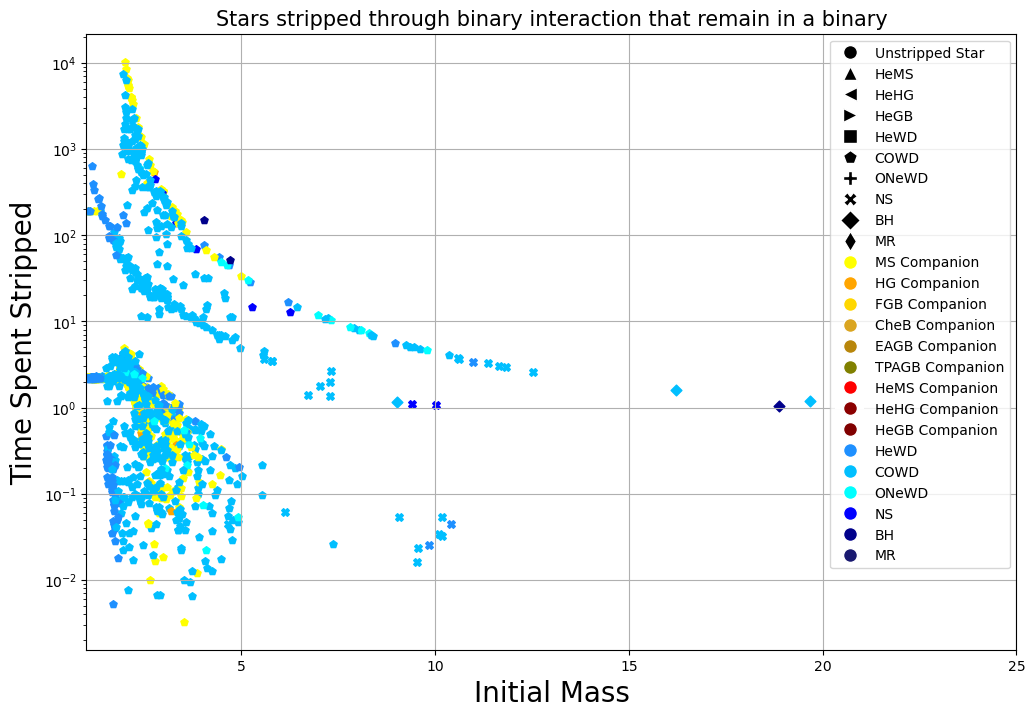

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

for i in range(len(set_BoundRLOFStripped[0])):
    plt.scatter( set_BoundRLOFStripped[0][i], set_BoundRLOFStripped[1][i],
                color = color_map[set_BoundRLOFStripped[3][i]],
                marker = type_map[set_BoundRLOFStripped[2][i]],
                s = 30
               )
for i in range(len(set_BoundCEStripped[0])):
    plt.scatter( set_BoundCEStripped[0][i], set_BoundCEStripped[1][i],
                color = color_map[set_BoundCEStripped[3][i]],
                marker = type_map[set_BoundCEStripped[2][i]],
                s = 30
               )

plt.xlabel('Initial Mass', fontsize=20)
plt.ylabel('Time Spent Stripped', fontsize=20)
plt.title('Stars stripped through binary interaction that remain in a binary', fontsize=15)

#plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 25)

plt.grid()

plt.legend(handles=legend_elements, loc='best')



In [27]:
# mask for the seeds in the lower left grid with masses below 5 solar mass and extremely low lifetimes
mass_age_mask1 = (np.array(set_BoundRLOFStripped[0]) <= 5) & (np.array(set_BoundRLOFStripped[1]) <= 10)
mass_age_mask2 = (np.array(set_BoundCEStripped[0]) <= 5) & (np.array(set_BoundCEStripped[1]) <= 10)

In [28]:
seeds1 = np.append(BoundRLOFStripped_seeds1, BoundRLOFStripped_seeds2)
seeds1 = seeds1[mass_age_mask1]
seeds2 = np.append(BoundCEStripped_seeds1, BoundCEStripped_seeds2)
seeds2 = seeds2[mass_age_mask2]

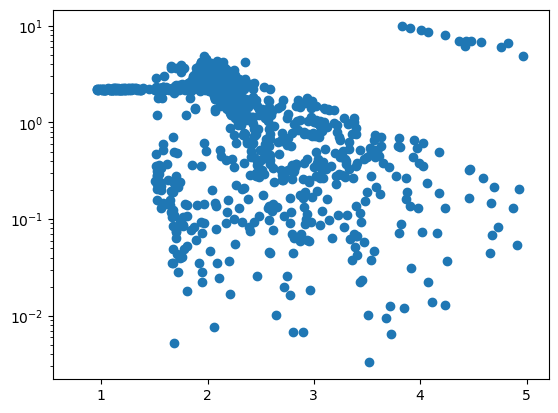

In [29]:
plt.scatter(np.array(set_BoundCEStripped[0])[mass_age_mask2], np.array(set_BoundCEStripped[1])[mass_age_mask2])

plt.yscale('log')

In [30]:
def generateGridAndArgsFilesForSeeds(myf=None, fname=None, seeds=None, fname_grid='recreated_grid.txt', fname_args='recreated_args.txt'):
    """
    Create the grid file (and args file, if necessary) to reproduce a set of seeds from a simulation.
    IN:
        myf: a COMPAS hdf5 file (must include either this or fname, not both)
        fname: the pathname to a COMPAS.h5 file (must include either this or myf, not both)
        seeds: the set of seeds to print out
        fname_grid: the name of the gridfile
        fname_args: the name of the argsfile
    """
    
    if (myf == None) == (fname == None):
        print("Need to specify one of myf or fname")
        return
    if (fname is not None):
        myf = h5.File(fname, 'r')
    if (seeds is None) or (len(seeds) < 1):
        print("Need to specify seeds")
        return
        
    RDs = myf['Run_Details']
    SPs = myf['BSE_System_Parameters']

    
    ### Extract the RDs args which are user supplied
    # Get value and derivation columns, regardless of how many are there in total
    df = printCompasDetails(RDs).iloc[:, [1,-1]] 
    # Get a dictionary mapping USER_SUPPLIED input args to values 
    args_dict = df[df['Derivation'] == 'USER_SUPPLIED'].iloc[:, 0].to_dict()
    # Get rid of args which are always irrelevant
    for key in ['grid', 'output-path', 'output-container', 'random-seed', 'number-of-systems']:
        args_dict.pop(key, None)

    spSeeds = SPs['SEED'][()].astype(int)
    mask = np.in1d(SPs['SEED'][()], seeds)

    ### Determine which parameters should go in the grid file 
    dictParamsOfInterest = {
            'initial-mass-1': SPs['Mass@ZAMS(1)'][()][mask],
            'initial-mass-2': SPs['Mass@ZAMS(2)'][()][mask],
            'semi-major-axis': SPs['SemiMajorAxis@ZAMS'][()][mask],
    }

    
    ### Define the parameters which should be checked in RDs, and if included, should be added to the grid
    # Parameters which do not apply to each star
    dictRdKeysToSpKeys = {
            'eccentricity' : 'Eccentricity@ZAMS',
    }
    # Parameters which apply to one star or the other
    dictRdKeysToSpKeysPerStar = {
        'kick-magnitude':        'Kick_Magnitude',
        'kick-magnitude-random': 'Kick_Magnitude_Random',
        'kick-mean-anomaly':     'Kick_Mean_Anomaly',
        'kick-phi':              'Kick_Phi',
        'kick-theta':            'Kick_Theta',
    }
    # Add these in with the appropriate star number
    dictRdKeysToSpKeys.update({ '{}-{}'.format(rdkey, which): '{}({})'.format(spkey, which) for which in [1, 2] for rdkey, spkey in dictRdKeysToSpKeysPerStar.items()})
    for rdkey, spkey in dictRdKeysToSpKeys.items():
        if rdkey in args_dict: # param was set manually
            dictParamsOfInterest.update({'--{}'.format(rdkey): SPs[spkey][()][mask]})
            del args_dict[rdkey] # remove from the args dict so it is not included in the args file
    
    
    ### Write the grid file, removing RDs args as needed
    with open(fname_grid, 'w') as fwrite:
        for ss, seed in enumerate(spSeeds[mask]):
            args_str = '--random-seed {} '.format(seed)
            args_str += ' '.join(['--{} {}'.format(key, val[ss]) for key, val in dictParamsOfInterest.items()]) + '\n'
            fwrite.write(args_str)

            
    ### Write the recreated_args.txt file
    if len(args_dict) > 0:
        with open(fname_args, 'w') as fwrite:
            args_str = ' '.join(['--{} {}'.format(key, val) for key, val in args_dict.items()])
            fwrite.write(args_str)
            
    print("Success!")
    print("Grid file: ", fname_grid)
    if len(args_dict) > 0:
        print("Args file: ", fname_args)
    else:
        print("No Args file produced")

In [31]:
generateGridAndArgsFilesForSeeds(myf=data, seeds=seeds1, fname_grid='RLOF_recreated_grid.txt', fname_args='RLOF_recreated_args.txt')

Success!
Grid file:  RLOF_recreated_grid.txt
Args file:  RLOF_recreated_args.txt


In [32]:
generateGridAndArgsFilesForSeeds(myf=data, seeds=seeds2, fname_grid='CE_recreated_grid.txt', fname_args='CE_recreated_args.txt')

Success!
Grid file:  CE_recreated_grid.txt
Args file:  CE_recreated_args.txt


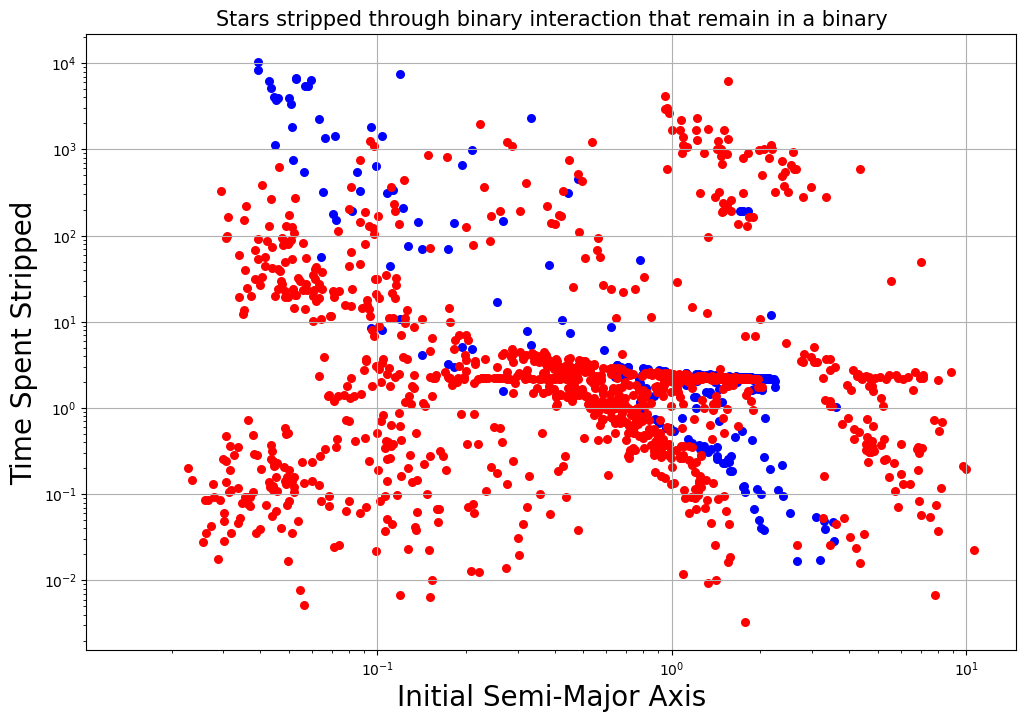

In [33]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

#for i in range(len(set_BoundRLOFStripped[0])):
plt.scatter( set_BoundRLOFStripped[4], set_BoundRLOFStripped[1],
            #color = color_map[set_BoundRLOFStripped[3][i]],
            #marker = type_map[set_BoundRLOFStripped[2][i]],
            s = 30, color='blue'
           )

#for i in range(len(set_BoundCEStripped[0])):
plt.scatter( set_BoundCEStripped[4], set_BoundCEStripped[1],
            #color = color_map[set_BoundCEStripped[3][i]],
            #marker = type_map[set_BoundCEStripped[2][i]],
            s = 30, color='red'
           )

plt.xlabel('Initial Semi-Major Axis', fontsize=20)
plt.ylabel('Time Spent Stripped', fontsize=20)
plt.title('Stars stripped through binary interaction that remain in a binary', fontsize=15)

plt.yscale('log')
plt.xscale('log')
plt.grid()

#plt.legend(handles=legend_elements, loc='best')

plt.savefig('semimajor_time.png')
plt.show()

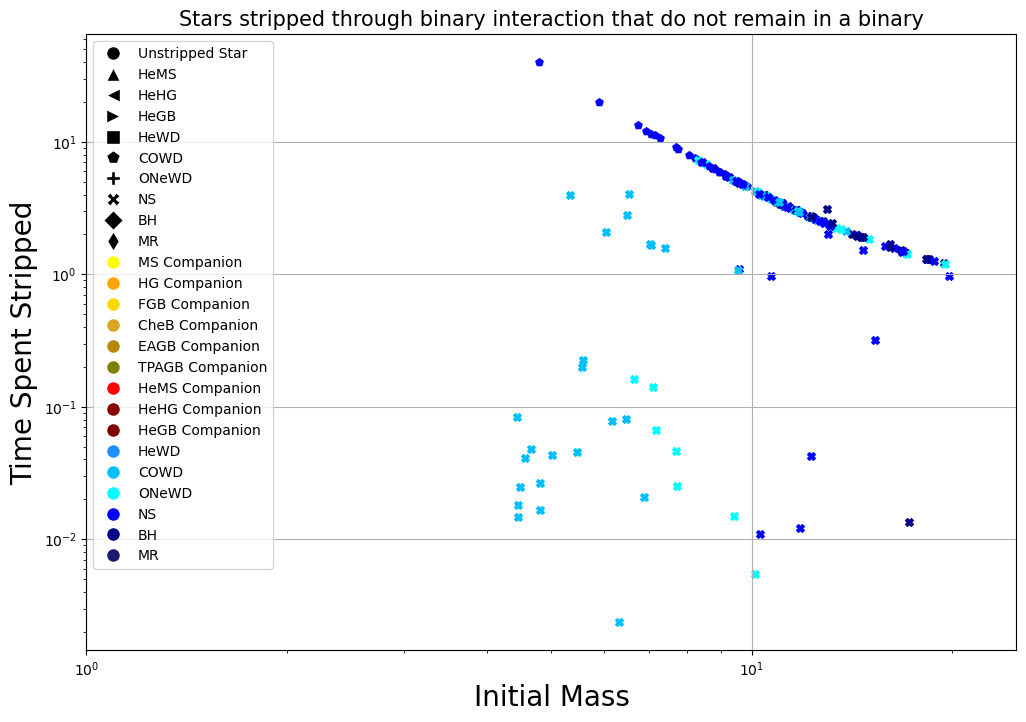

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

for i in range(len(set_UnboundRLOFStripped[0])):
    plt.scatter( set_UnboundRLOFStripped[0][i], set_UnboundRLOFStripped[1][i],
                color = color_map[set_UnboundRLOFStripped[3][i]],
                marker = type_map[set_UnboundRLOFStripped[2][i]],
                s = 30
               )
for i in range(len(set_UnboundCEStripped[0])):
    plt.scatter( set_UnboundCEStripped[0][i], set_UnboundCEStripped[1][i],
                color = color_map[set_UnboundCEStripped[3][i]],
                marker = type_map[set_UnboundCEStripped[2][i]],
                s = 30
               )

plt.xlabel('Initial Mass', fontsize=20)
plt.ylabel('Time Spent Stripped', fontsize=20)
plt.title('Stars stripped through binary interaction that do not remain in a binary', fontsize=15)

plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 25)

plt.grid()

plt.legend(handles=legend_elements, loc='best')

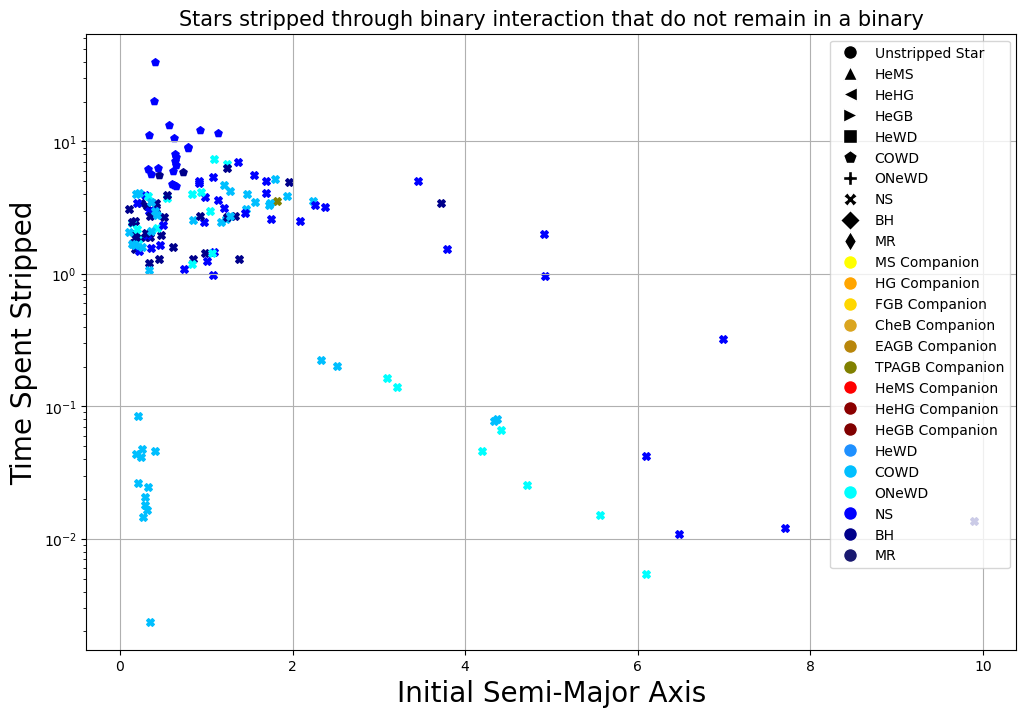

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

for i in range(len(set_UnboundRLOFStripped[0])):
    plt.scatter( set_UnboundRLOFStripped[4][i], set_UnboundRLOFStripped[1][i],
                color = color_map[set_UnboundRLOFStripped[3][i]],
                marker = type_map[set_UnboundRLOFStripped[2][i]],
                s = 30
               )
for i in range(len(set_UnboundCEStripped[0])):
    plt.scatter( set_UnboundCEStripped[4][i], set_UnboundCEStripped[1][i],
                color = color_map[set_UnboundCEStripped[3][i]],
                marker = type_map[set_UnboundCEStripped[2][i]],
                s = 30
               )

plt.xlabel('Initial Semi-Major Axis', fontsize=20)
plt.ylabel('Time Spent Stripped', fontsize=20)
plt.title('Stars stripped through binary interaction that do not remain in a binary', fontsize=15)

plt.yscale('log')

plt.grid()

plt.legend(handles=legend_elements, loc='best')

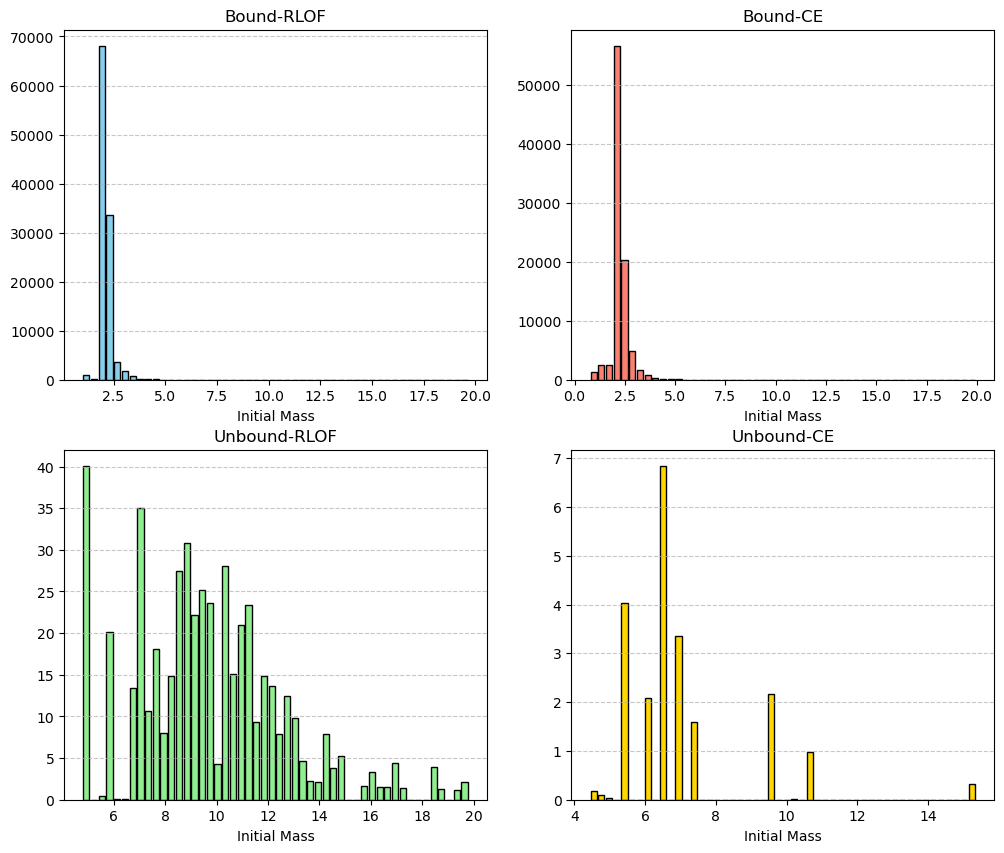

In [36]:
fig, ax = plt.subplots(2,2,figsize=(12, 10))

ax[0][0].hist(set_BoundRLOFStripped[0], bins=50, weights=set_BoundRLOFStripped[1], rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[0][0].set_xlabel('Initial Mass')
ax[0][0].set_title('Bound-RLOF')
ax[0][0].grid(axis='y', linestyle='--', alpha=0.7)

ax[0][1].hist(set_BoundCEStripped[0], bins=50, weights=set_BoundCEStripped[1], rwidth=0.8, edgecolor='black', color='salmon', label='Bound-CE')
ax[0][1].set_xlabel('Initial Mass')
ax[0][1].set_title('Bound-CE')
ax[0][1].grid(axis='y', linestyle='--', alpha=0.7)

ax[1][0].hist(set_UnboundRLOFStripped[0], bins=50, weights=set_UnboundRLOFStripped[1], rwidth=0.8, edgecolor='black', color='lightgreen', label='Unbound-RLOF')
ax[1][0].set_xlabel('Initial Mass')
ax[1][0].set_title('Unbound-RLOF')
ax[1][0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1][1].hist(set_UnboundCEStripped[0], bins=50, weights=set_UnboundCEStripped[1], rwidth=0.8, edgecolor='black', color='gold', label='Unbound-CE')
ax[1][1].set_xlabel('Initial Mass')
ax[1][1].set_title('Unbound-CE')
ax[1][1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

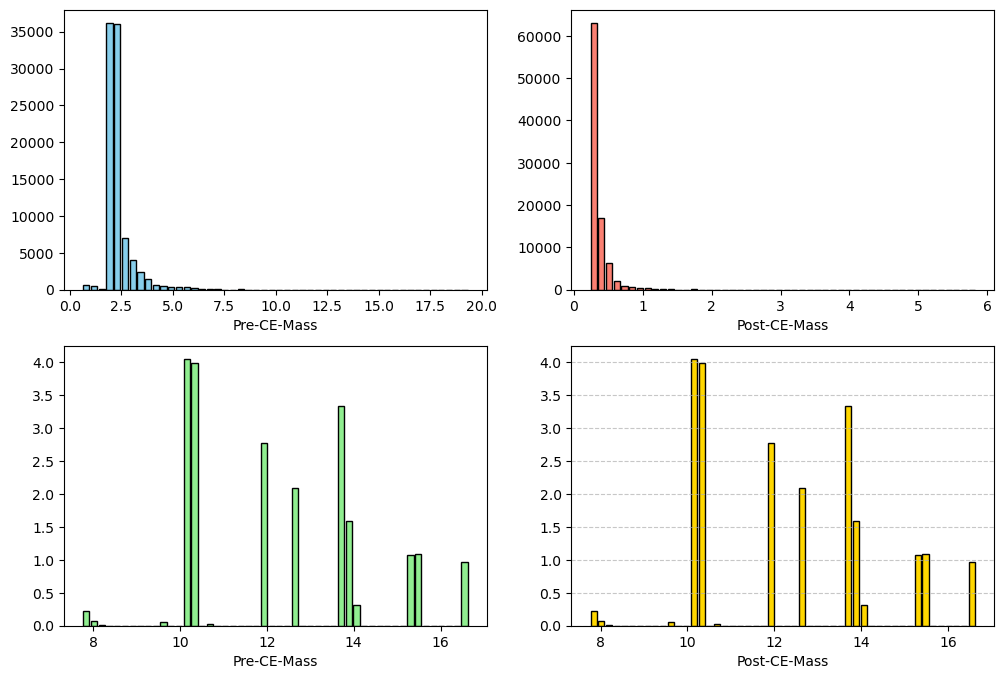

In [37]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))

ax[0][0].hist(set_BoundCEStripped[5], bins=50, weights=set_BoundCEStripped[1], rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[0][0].set_xlabel('Pre-CE-Mass')

ax[0][1].hist(set_BoundCEStripped[6], bins=50, weights=set_BoundCEStripped[1], rwidth=0.8, edgecolor='black', color='salmon', label='Bound-CE')
ax[0][1].set_xlabel('Post-CE-Mass')

ax[1][0].hist(set_UnboundCEStripped[5], bins=50, weights=set_UnboundCEStripped[1], rwidth=0.8, edgecolor='black', color='lightgreen', label='Unbound-RLOF')
ax[1][0].set_xlabel('Pre-CE-Mass')

ax[1][1].hist(set_UnboundCEStripped[5], bins=50, weights=set_UnboundCEStripped[1], rwidth=0.8, edgecolor='black', color='gold', label='Unbound-CE')
ax[1][1].set_xlabel('Post-CE-Mass')


plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [38]:
full_set_initmass = set_BoundRLOFStripped[0] + set_BoundCEStripped[0] + set_UnboundRLOFStripped[0] + set_UnboundCEStripped[0]
full_set_time = set_BoundRLOFStripped[1] + set_BoundCEStripped[1] + set_UnboundRLOFStripped[1] + set_UnboundCEStripped[1]

ce_set_initmass = set_BoundCEStripped[0] + set_UnboundCEStripped[0]
full_set_precemass = set_BoundCEStripped[5] + set_UnboundCEStripped[5]
full_set_postcemass = set_BoundCEStripped[6] + set_UnboundCEStripped[6]
set_time_ce = set_BoundCEStripped[1] + set_UnboundCEStripped[1]

NameError: name 'bins' is not defined

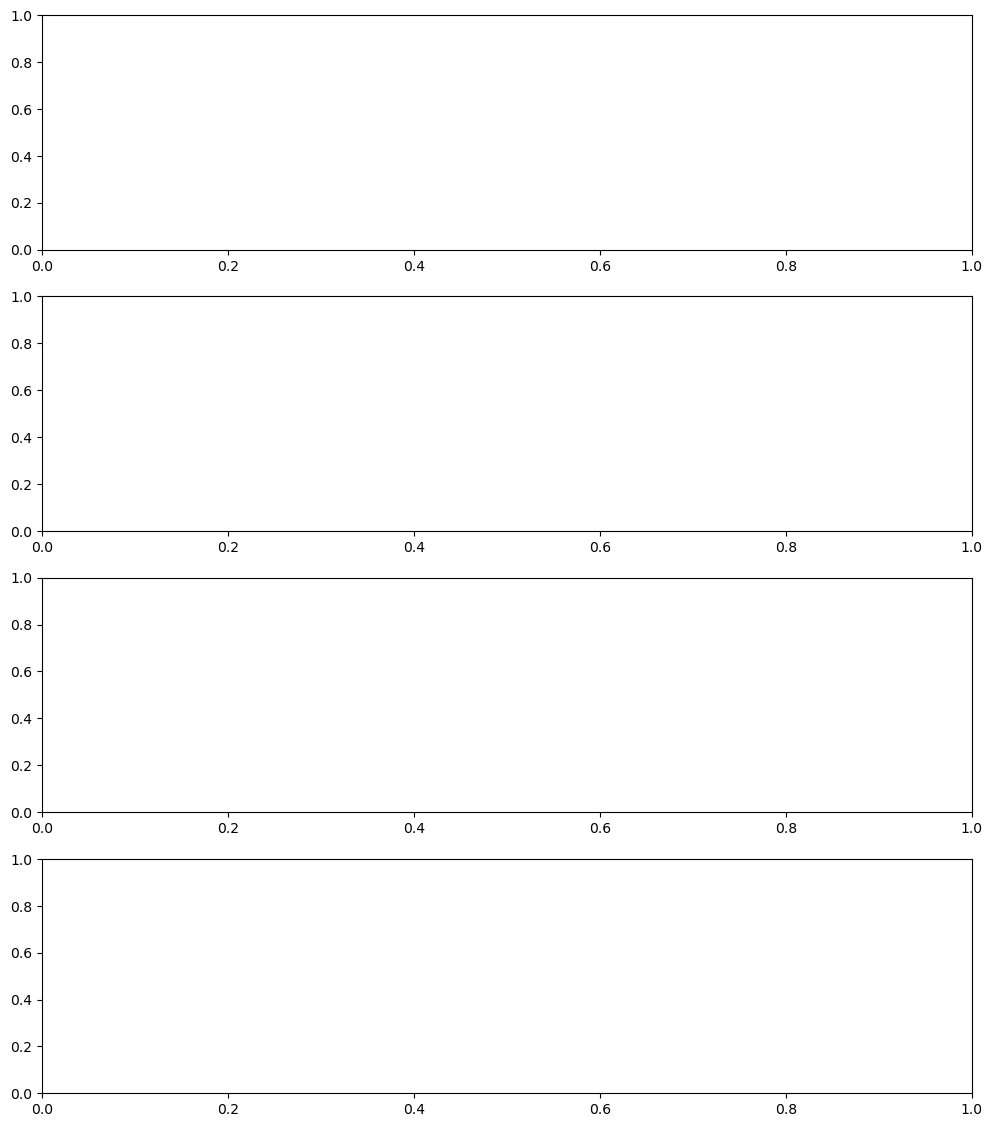

In [39]:
fig, ax = plt.subplots(4,1,figsize=(12, 14))

ax[0].hist(full_set_initmass, bins=bins, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[0].set_xlabel('Initial Mass')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].set_xlim(0,10)

ax[1].hist(full_set_precemass, bins=bins, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[1].set_xlabel('Pre-CE-Mass')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_xlim(0,10)

ax[2].hist(full_set_postcemass, bins=bins, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[2].set_xlabel('Post-CE-Mass')
ax[2].grid(axis='y', linestyle='--', alpha=0.7)
ax[2].set_xlim(0,10)


ax[3].hist(full_set_postcemass, bins=bins, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[3].set_xlabel('Post-CE-Mass')
ax[3].grid(axis='y', linestyle='--', alpha=0.7)
ax[3].set_xlim(0,4)



plt.savefig('Histogram_MassTimeStripped.png')
plt.show()

In [1]:
fig, ax = plt.subplots(4,1,figsize=(12, 12))
bins=np.linspace(0,10,51)

ax[0].hist(full_set_initmass, bins=bins, weights=full_set_time, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[0].set_xlabel('Initial Mass')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].set_xlim(0,10)

ax[1].hist(full_set_precemass, bins=bins, weights=set_time_ce, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[1].set_xlabel('Pre-CE-Mass')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_xlim(0,10)

ax[2].hist(full_set_postcemass, bins=bins, weights=set_time_ce, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[2].set_xlabel('Post-CE-Mass')
ax[2].grid(axis='y', linestyle='--', alpha=0.7)
ax[2].set_xlim(0,10)

ax[3].hist(full_set_postcemass, bins=bins, weights=set_time_ce, rwidth=0.8, edgecolor='black', color='skyblue', label='Bound-RLOF')
ax[3].set_xlabel('Post-CE-Mass')
ax[3].grid(axis='y', linestyle='--', alpha=0.7)
ax[3].set_xlim(0,4)

plt.savefig('weighted_histogram.png')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
kde_postcemass = gaussian_kde(full_set_postcemass, weights=set_time_ce)
kde_initmass =  gaussian_kde(ce_set_initmass, weights=set_time_ce)

In [ ]:
mass_range1 = np.linspace(0, 20, 1000)
plt.plot(mass_range1, kde_postcemass(mass_range1), color='skyblue')
plt.fill_between(mass_range1, kde_postcemass(mass_range1), color='skyblue', alpha=0.3)

plt.vlines(0.45, 0, 2.7)
plt.ylim(0,2.7)
plt.xlim(0,2.5)
plt.xlabel('Post-CE Mass of Stars')
plt.ylabel('Weighted Density by Time as Stripped Star')
plt.title('Weighted KDE of Star Initial Masses by Time as Stripped Star')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
mass_range1 = np.linspace(0, 20, 1000)
plt.plot(mass_range1, kde_initmass(mass_range1), color='skyblue')
plt.fill_between(mass_range1, kde_initmass(mass_range1), color='skyblue', alpha=0.3)

plt.xlabel('Initial Mass of Stars')
plt.ylabel('Weighted Density by Time as Stripped Star')
plt.title('Weighted KDE of Star Initial Masses by Time as Stripped Star')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
SPs.keys()

In [49]:
RLOF.keys()

<KeysViewHDF5 ['Beta', 'CEE>MT', 'Eccentricity<MT', 'Eccentricity>MT', 'MT_Event_Counter', 'Mass(1)<MT', 'Mass(1)>MT', 'Mass(2)<MT', 'Mass(2)>MT', 'MassTransferRateDonor', 'Merger', 'RLOF(1)<MT', 'RLOF(1)>MT', 'RLOF(2)<MT', 'RLOF(2)>MT', 'Radius(1)<MT', 'Radius(1)>MT', 'Radius(1)|RL<step', 'Radius(1)|RL>step', 'Radius(2)<MT', 'Radius(2)>MT', 'Radius(2)|RL<step', 'Radius(2)|RL>step', 'Record_Type', 'SEED', 'SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(1)>MT', 'Stellar_Type(2)<MT', 'Stellar_Type(2)>MT', 'Time<MT', 'Time>MT', 'Zeta_Hurley(1)', 'Zeta_Hurley(2)', 'Zeta_Hurley_He(1)', 'Zeta_Hurley_He(2)', 'Zeta_Soberman(1)', 'Zeta_Soberman(2)', 'Zeta_Soberman_He(1)', 'Zeta_Soberman_He(2)']>